<a href="https://colab.research.google.com/github/deepintomlf/mlfbook/blob/master/Chapter2_Supervised_Learning/ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **第二章 - 监督学习**

这个Jupyter笔记本包含了第二章的所有源代码.

## **数值实验**

### **预处理MNIST数据集**


In [0]:
import numpy as np
from keras.datasets import mnist 

# 加载MNIST数据集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
[n_samples_train, width, height] = np.shape(x_train)
[n_samples_test, width, height] = np.shape(x_test)

X_train = x_train.reshape([n_samples_train, width*height])
X_test =x_test.reshape([n_samples_test, width*height])
Y_train = (y_train==8)
Y_test= (y_test==8)

False    54149
True      5851
dtype: int64


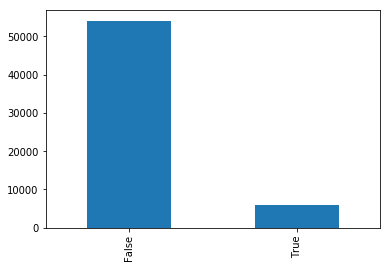

In [37]:
import pandas as pd

y_pd = pd.Series(Y_train)
count_y = y_pd.value_counts().sort_index()
count_y.plot(kind='bar');
print(count_y)

False    9026
True      974
dtype: int64


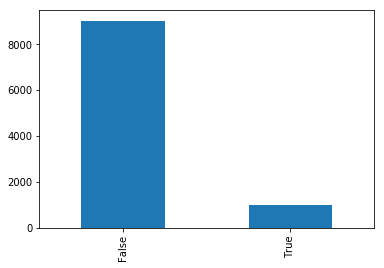

In [30]:
y_test_pd = pd.Series(Y_test)
count_y_test = y_test_pd.value_counts().sort_index()
count_y_test.plot(kind='bar');
print(count_y_test)

### **使用Scikit-learn建立逻辑回归模型**

In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, solver='lbfgs')
clf = model.fit(X_train, Y_train)

# 预测标签
y_train_est = clf.predict(X_train)
y_train_prob_est = clf.predict_proba(X_train)

# 预测概率
y_test_est = clf.predict(X_test)
y_test_prob_est = clf.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [53]:
temp = pd.DataFrame(y_train_prob_est)
temp.columns = ['class 1 (non 8)', 'class 2 (digit 8)']
print('conditional probability estimator')
temp.head(15)

conditional probability estimator


,class 1 (non 8),class 2 (digit 8)
0,0.999929,0.000071
1,0.999096,0.000904
2,0.999970,0.000030
3,0.877981,0.122019
4,0.999048,0.000952
5,0.982514,0.017486
6,0.993879,0.006121
7,0.918145,0.081855
8,0.962651,0.037349
9,0.993038,0.006962


In [0]:
temp = pd.Series(y_test_prob_est[1])
temp.head()

In [0]:
temp1 = pd.DataFrame(y_train_est)
temp1.columns = ['class 1 (non 8)']	
print('estimated output')
temp1.head(15)

### **输出混淆矩阵**

In [49]:
from sklearn.metrics import confusion_matrix

# Y_test和y_test_est分别表示真实标签和预测标签
cm = confusion_matrix(Y_test, y_test_est)
print('confusion matrix is {}'.format(cm))

confusion matrix is [[8810  216]
 [ 319  655]]


### **计算准确率、精确率、召回率**

In [50]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(Y_train, y_train_est)
acc_test = accuracy_score(Y_test, y_test_est)
print('accuracy of the train set= {}'.format(acc_train))
print('accuracy of the testing set= {}'.format(acc_test))

accuracy of the train set= 0.95065
accuracy of the testing set= 0.9465


In [51]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(Y_test, y_test_est)
recall = recall_score(Y_test, y_test_est)
print(precision)
print(recall)

0.7520091848450058
0.6724845995893224


### **绘制PR曲线**

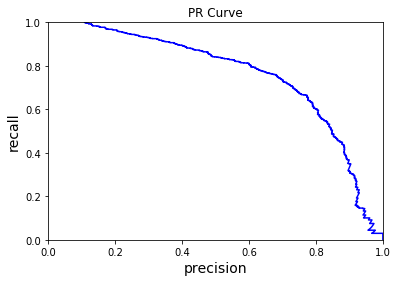

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(Y_test, y_test_prob_est[:,1])
plt.plot(precisions, recalls, 'b')
plt.xlabel('precision', fontsize=14)
plt.ylabel('recall', fontsize=14)
plt.title('PR Curve')
plt.axis([0, 1, 0, 1])
plt.savefig('binary_classfication_PR_curve.png')

### **绘制ROC曲线**

roc auc score = 0.9423430418444366


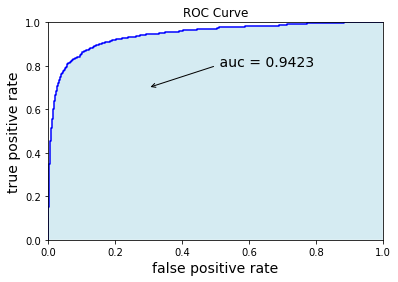

In [68]:
from sklearn.metrics import roc_curve, roc_auc_score

fps, tps, thresholds = roc_curve(Y_test, y_test_prob_est[:,1])
roc_auc_score_train = roc_auc_score(Y_test, y_test_prob_est[:,1])

print('roc auc score = {}'.format(roc_auc_score_train))

plt.plot(fps, tps, 'b')
plt.xlabel('false positive rate', fontsize=14)
plt.ylabel('true positive rate', fontsize=14)
plt.title('ROC Curve')
plt.axis([0, 1, 0, 1])
plt.fill_between(fps, 0, tps, facecolor='lightblue', alpha=0.5)
plt.text( 0.5, 0.8, ' auc = '+str(round(roc_auc_score_train, 4)), fontsize=14)
plt.annotate("", xy=(0.3, 0.7), xycoords='data', xytext=(0.5, 0.8), textcoords='data', 
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), )
plt.savefig('binary_classification_ROC_curve.png')

## **集成方法**

### **定义弱分类器和集成模型**

In [0]:
import numpy as np

def weak_learner():
    ''' 定义一个只有55%准确率的弱分类器 '''
    n = np.random.randint(0, 100)
    return (2 if n >=45 else 1)
     
def majority_voting(results:list):
    ''' 定义多数投票法 '''
    return (2 if results.count(2) >= results.count(1) else 1)

def ensemble_model(learner, num_learners=1000):
    ''' 定义1000个弱分类器的集成模型 '''
    all_res = []
    for i in range(num_learners):
        res = learner()
        all_res.append(res)
    return majority_voting(all_res)

### **模拟单个弱分类器和集成模型的准确率**

In [74]:
# 模拟10, 000个样本
num_samples = 10000
all_weak_learner_res = []
all_ensemble_model_res = []

for i in range(num_samples):
    weak_learner_res = weak_learner()
    ensemble_model_res = ensemble_model(weak_learner)
    all_weak_learner_res.append(weak_learner_res)
    all_ensemble_model_res.append(ensemble_model_res)

# 计算准确率
weak_learner_acc, ensemble_model_acc = all_weak_learner_res.count(2)/num_samples, all_ensemble_model_res.count(2)/num_samples

# 查看模拟结果
print('The accuracy of the weak learner is only {}'.format(weak_learner_accuracy)) 
print('The ensemble model achieves accuracy as high as {}'.format(ensemble_model_accuracy))

The accuracy of the weak learner is only 0.5411
The ensemble model achieves accuracy as high as 1.0


### **不同学习器数量的集成模型的准确率**

In [0]:
# 模拟不同弱分类器个数的集成模型的准确率
num_learners = np.arange(1,1000,10)
all_acc = []

for i in num_learners:
    np.random.seed(0)
    num_samples = 1000
    all_ensemble_model_res = []
    for j in range(num_samples):
        ensemble_model_res = ensemble_model(weak_learner, i)
        all_ensemble_model_res.append(ensemble_model_res)
        ensemble_model_acc = all_ensemble_model_res.count(2)/num_samples
    all_acc.append(ensemble_model_acc)

Text(0, 0.5, 'Accuracy')

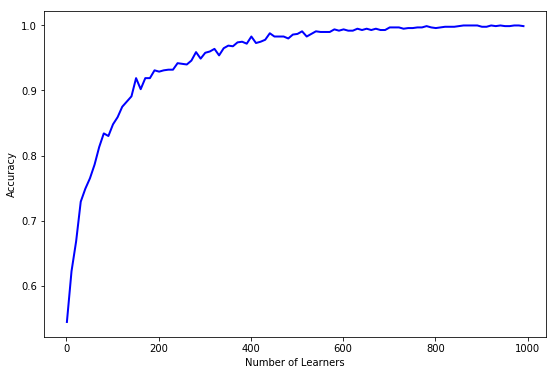

In [15]:
import matplotlib.pyplot as plt

# 绘制不同集成模型的准确率
plt.figure(figsize = (9, 6))
plt.plot(num_learners, all_acc, 'b', linewidth = 2)
plt.xlabel('Number of Learners')
plt.ylabel('Accuracy')